# HMM Views IC Frontier: Oldest Country ETFs

## 1. Data Fetching

### 1.1 Model configuration

In [1]:
import os
import sys
import datetime as dt
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm

import cvxportfolio as cp
import alphamodel as am

config = {'name': 'bl_hmm_sim',
          'universe':
              {'list': ['SPY', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWS', 'EWU', 'EWW'],
               'ticker_col': 'Symbol',
               'risk_free_symbol': 'USDOLLAR'},
          'data':
              {'name': 'eod_returns',
               'source': 'quandl',
               'table': 'EOD',
               'api_key': "6XyApK2BBj_MraQg2TMD"},
          'model':
              {'start_date': '19970102',
               'end_date': '20011231',
               'halflife': 20,
               'min_periods': 3,
               'hidden_states': 2,
               'train_len': 750,
               'data_dir': '/Users/razvan/PyRepo/research_masc/data_store/hmm/',
               'returns':
                   {'sampling_freq': 'daily'},
               'covariance':
                    {'method' : 'FF5',
                     'sampling_freq' : 'monthly',
                     'train_days': 90}
              }
         }

/Users/razvan/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### 1.2 Fetch return data

In [2]:
# Fetch returns / volumes
ss = am.SingleStockHMM(config)
ss.train(force=True)

downloading SPY from 19970102 to 20011231
downloading EWA from 19970102 to 20011231
downloading EWC from 19970102 to 20011231
downloading EWG from 19970102 to 20011231
downloading EWH from 19970102 to 20011231
downloading EWJ from 19970102 to 20011231
downloading EWS from 19970102 to 20011231
downloading EWU from 19970102 to 20011231
downloading EWW from 19970102 to 20011231
downloading USDOLLAR from 19970102 to 20011231
Removing these days from dataset:
            nan price
1999-04-02          9
2001-09-13          9
2001-09-14          9
          remaining nan price
SPY                         0
EWA                         0
EWC                         0
EWG                         0
EWH                         0
EWJ                         0
EWS                         0
EWU                         0
EWW                         0
USDOLLAR                   10
Proceeding with forward fills to remove remaining NaNs


True

### 1.3 Return Volatility

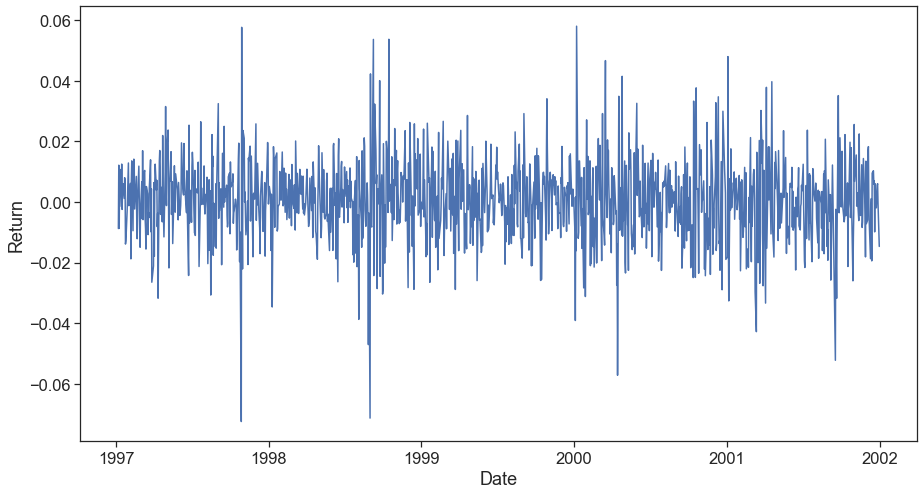

In [7]:
returns = ss.get('returns', 'realized')

# Plot return time series over training set
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

with sns.axes_style('ticks'):
    ax = sns.lineplot(x='Date', y='SPY', data=returns.reset_index())
    ax.set(xlabel='Date', ylabel='Return')
    plt.savefig(ss.cfg['data_dir'] + 'spy_returns.png')

### 1.4 Return Distribution over Time

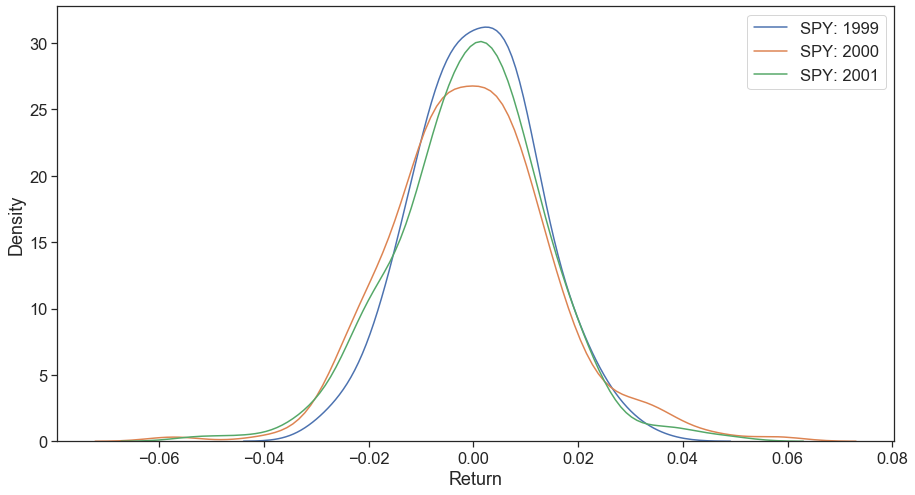

In [8]:
# Plot return density for 3 years
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

with sns.axes_style('ticks'):    
    ax = sns.kdeplot(data=returns[(returns.index >= dt.datetime(1999, 1, 1)) & (returns.index <= dt.datetime(1999, 12, 31))].loc[:, 'SPY'],
                bw=5e-3, label="SPY: 1999")
    sns.kdeplot(data=returns[(returns.index >= dt.datetime(2000, 1, 1)) & (returns.index <= dt.datetime(2000, 12, 31))].loc[:, 'SPY'],
                bw=5e-3, label="SPY: 2000")
    sns.kdeplot(data=returns[(returns.index >= dt.datetime(2001, 1, 1)) & (returns.index <= dt.datetime(2001, 12, 31))].loc[:, 'SPY'],
                bw=5e-3, label="SPY: 2001")
    plt.legend()
    ax.set(xlabel='Return', ylabel='Density')
    plt.savefig(ss.cfg['data_dir'] + 'spy_kde_years.png')

## 2. HMM information coefficient frontier

Hyperparameters:
- hmm_mode: return prediction, 'e' (expectation), 't' (regime over probability threshold)
- preprocess: raw data or exponential decay
- train_len: length of training data
- halflife: halflife of exponential decay

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

ic_vs_params = {}

for hmm_mode in ['e', 't']:
    for preprocess in [None, 'exponential']:
        for train_len in range(50, 1501, 50):
            for halflife in [65, 130, 250, 500, 750]:
                # Avoid cases we don't want to run
                if (not preprocess and halflife > 65) or train_len < halflife:
                    continue
                
                # Set the parameters for the prediction
                ss.cfg['train_len'] = train_len
                ss.cfg['halflife'] = halflife

                # Predict and gather metrics
                ss.predict(mode=hmm_mode, preprocess=preprocess)
                ic = ss.prediction_quality(statistic='information_coefficient', print=False)

                # Save down metrics together with parameters
                key = hmm_mode + str(preprocess) + str(train_len) + str(halflife)
                ic_vs_params[key] = [hmm_mode, preprocess, train_len, ic.loc[5, 'mean'], ic.loc[5, 'std']]

        # Save down values in .csv
        ic_df = pd.DataFrame.from_dict(ic_vs_params, orient='index')
        ic_df.columns = ['hmm_mode', 'preprocess', 'train_len', 'ic_5d_mean', 'ic_5d_std']
        ic_df.to_csv(ss.cfg['data_dir'] + 'hmm_ic.csv', index=False)

### 2.1 Frontier: expected return, no preprocessing

In [9]:
# Get the data
data = pd.read_csv(ss.cfg['data_dir'] + 'hmm_ic.csv')
e_raw = data[(data.loc[:, 'hmm_mode'] == 'e') & (pd.isna(data.loc[:, 'preprocess']))]
e_raw[e_raw.loc[:, 'halflife'] == 65]

,hmm_mode,preprocess,train_len,halflife,ic_5d_mean,ic_5d_std
0,e,NaN,100,65,0.037037,0.036972
1,e,NaN,150,65,0.067887,0.024140
2,e,NaN,200,65,0.072117,0.031077
3,e,NaN,250,65,0.063752,0.039257
4,e,NaN,300,65,0.054961,0.036323
5,e,NaN,350,65,0.052913,0.040688
6,e,NaN,400,65,0.059223,0.051289
7,e,NaN,450,65,0.058528,0.059332
8,e,NaN,500,65,0.064978,0.053474
9,e,NaN,550,65,0.070636,0.050411


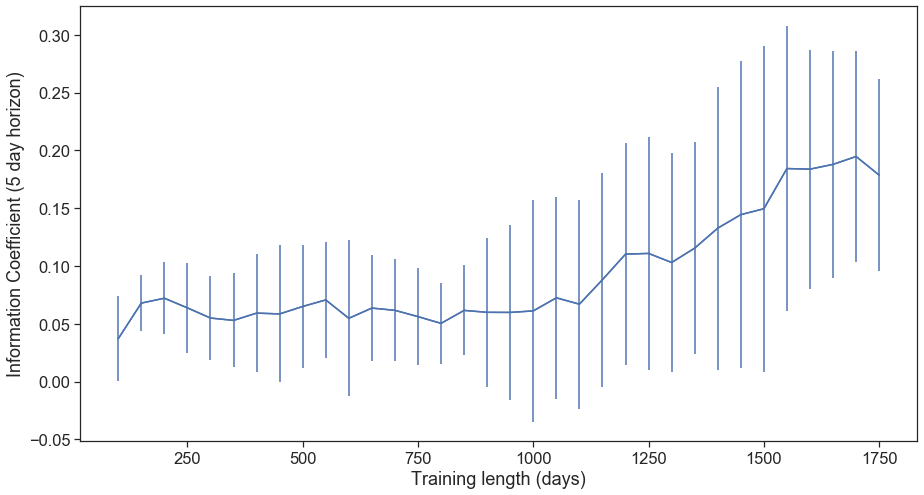

In [10]:
# Plot the IC versus train length
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

with sns.axes_style('ticks'):
    data = e_raw[e_raw.loc[:, 'halflife'] == 65]
    ax = sns.lineplot(x='train_len', y='ic_5d_mean', data=data)
    ax.errorbar(data['train_len'], data['ic_5d_mean'], yerr=data['ic_5d_std'], fmt='-b')
    #ax.set_title('HMM views - raw data, return in expectation')
    ax.set(xlabel='Training length (days)', ylabel='Information Coefficient (5 day horizon)')
    plt.savefig(ss.cfg['data_dir'] + 'hmm_ic_trainlen.png')

### 2.2 Frontier: Threshold to use

In [11]:
# Get the data
t_raw = pd.read_csv(ss.cfg['data_dir'] + 'hmm_ic_threshold.csv')
t_raw

,hmm_mode,preprocess,train_len,threshold,ic_5d_mean,ic_5d_std,mean_changes_mean,mean_changes_std,mean_change_rate_mean,mean_change_rate_std,regime_changes_mean,regime_changes_std,regime_change_rate_mean,regime_change_rate_std,periods_mean,periods_std
0,t,None,1700,0.700,0.188869,0.102882,516.666667,8.200610,0.917703,0.014566,11.222222,18.972202,0.019933,0.033698,563.0,0.0
1,t,None,1700,0.750,0.186106,0.098630,514.444444,8.847473,0.913756,0.015715,11.222222,18.972202,0.019933,0.033698,563.0,0.0
2,t,None,1700,0.800,0.186106,0.097018,513.000000,8.455767,0.911190,0.015019,11.222222,18.972202,0.019933,0.033698,563.0,0.0
3,t,None,1700,0.850,0.185317,0.095404,507.888889,10.647118,0.902112,0.018911,11.000000,19.078784,0.019538,0.033888,563.0,0.0
4,t,None,1700,0.900,0.184527,0.093855,498.666667,15.684387,0.885731,0.027859,10.888889,19.140562,0.019341,0.033997,563.0,0.0
5,t,None,1700,0.925,0.185317,0.093128,488.666667,22.533309,0.867969,0.040024,10.888889,19.140562,0.019341,0.033997,563.0,0.0
6,t,None,1700,0.950,0.184133,0.094523,461.333333,44.933284,0.819420,0.079810,10.666667,19.267849,0.018946,0.034224,563.0,0.0
7,t,None,1700,0.960,0.188080,0.098785,434.666667,69.758512,0.772054,0.123905,10.222222,18.965612,0.018157,0.033687,563.0,0.0
8,t,None,1700,0.970,0.190448,0.101484,376.111111,122.984190,0.668048,0.218444,9.444444,17.763102,0.016775,0.031551,563.0,0.0
9,t,None,1700,0.975,0.191237,0.100477,329.888889,145.707279,0.585948,0.258805,8.666667,15.842980,0.015394,0.028140,563.0,0.0


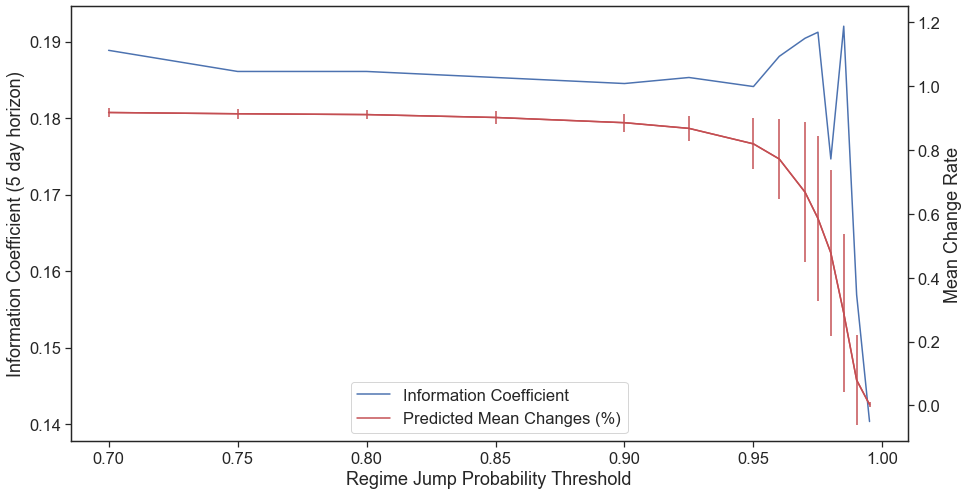

In [17]:
# Plot the IC versus train length
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

with sns.axes_style('ticks'):
    data = t_raw
    ax = sns.lineplot(x='threshold', y='ic_5d_mean', data=data, label='Information Coefficient', color='b')
    ax.set(xlabel='Regime Jump Probability Threshold', ylabel='Information Coefficient (5 day horizon)')
    ax.twinx()
    
    ax2 = sns.lineplot(x='threshold', y='mean_change_rate_mean', data=data, label='Predicted Mean Changes (%)', color='r')
    ax2.errorbar(data['threshold'], data['mean_change_rate_mean'], yerr=data['mean_change_rate_std'], fmt='-r')
    ax2.set(xlabel='Regime Jump Probability Threshold', ylabel='Mean Change Rate')
    ax2.legend().remove()
    
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc='lower center')
    plt.ylim(plt.ylim()[0], 1.25)
    plt.savefig(ss.cfg['data_dir'] + 'hmm_ic_threshold_mean.png')

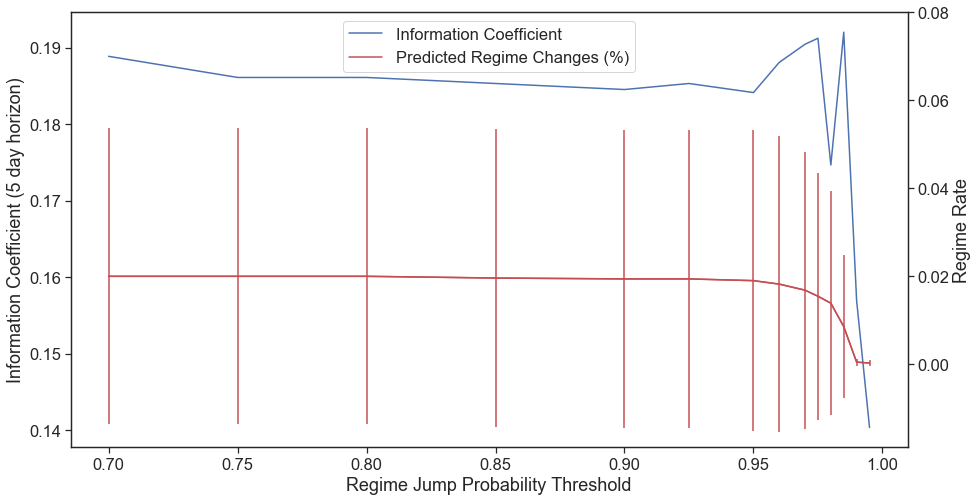

In [16]:
# Plot the IC versus train length
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

with sns.axes_style('ticks'):
    data = t_raw
    ax = sns.lineplot(x='threshold', y='ic_5d_mean', data=data, label='Information Coefficient', color='b')
    ax.set(xlabel='Regime Jump Probability Threshold', ylabel='Information Coefficient (5 day horizon)')
    ax.twinx()
    
    ax2 = sns.lineplot(x='threshold', y='regime_change_rate_mean', data=data, label='Predicted Regime Changes (%)', color='r')
    ax2.errorbar(data['threshold'], data['regime_change_rate_mean'], yerr=data['regime_change_rate_std'], fmt='-r')
    ax2.set(xlabel='Regime Jump Probability Threshold', ylabel='Regime Rate')
    ax2.legend().remove()
    
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc='upper center')
    plt.ylim(plt.ylim()[0], 0.08)
    plt.savefig(ss.cfg['data_dir'] + 'hmm_ic_threshold_regime.png')

## Playground

In [36]:
# library
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Get the data
data = pd.read_csv(ss.cfg['data_dir'] + 'hmm_ic.csv')
e_exp = data[(data.loc[:, 'hmm_mode'] == 'e') & (data.loc[:, 'preprocess'] == 'exponential')]

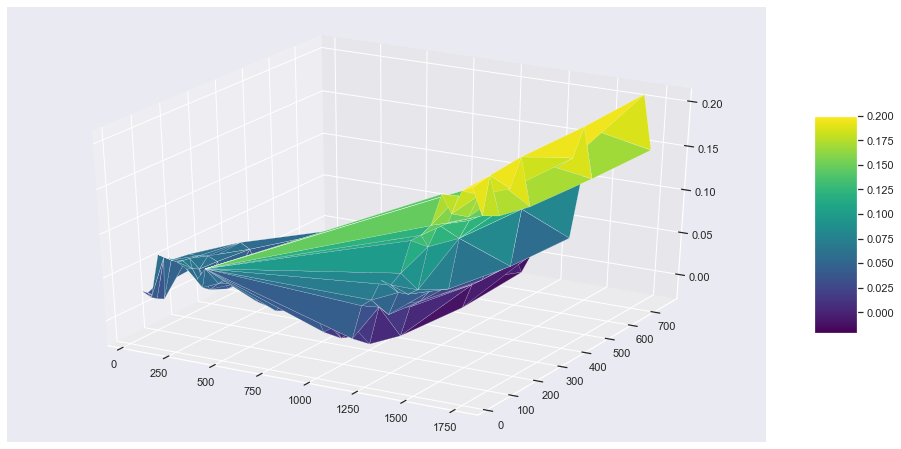

In [38]:
# Make the plot
fig = plt.figure(figsize=(17,8))
ax = fig.gca(projection='3d')

# Add a color bar which maps values to colors
surf=ax.plot_trisurf(e_exp['train_len'], e_exp['halflife'], e_exp['ic_5d_mean'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
#ax.view_init(0,45)
plt.show()